# Running the spectral graph model using the classes branch. 

Trying out functionality to debug. 

### Import modules

In [1]:
import sys
sys.path.append("..")

#SCFC modules
from forward import network_transfer as nt
from utils import functions
from brain import Brain
from read import data_reader as dr
from preprocess import permute as perm 
from utils import path as pth
from preprocess import filters

#generic modules
import matplotlib.pyplot as mpl
%matplotlib inline
import numpy as np
from scipy.signal import lfilter, firls, decimate
import time

### Create an instance of a brain and do basic operations.

In [2]:
mybrain = Brain.Brain()

In [3]:
directory = pth.get_sibling_path('data')

In [4]:
mybrain.add_connectome(directory)

In [5]:
mybrain.connectome.size

7396

In [6]:
mybrain.reorder_connectome(mybrain.connectome, mybrain.distance_matrix)

In [7]:
mybrain.distance_matrix.shape

(86, 86)

In [8]:
vars(mybrain).keys()

dict_keys(['connectome', 'reducedConnectome', 'distance_matrix', 'permutation', 'ordering', 'ntf_params'])

Get the reduced form of the connectome using these mysterious functions. 

In [9]:
mybrain.bi_symmetric_c()
mybrain.reduce_extreme_dir()

### Running the network transfer model on the brain class

Do the calculation of the NTF for a single frequency.

In [10]:
fq, ev, Vv, freqresp_out, _ = nt.network_transfer_function(mybrain, 
                                                           parameters = mybrain.ntf_params, 
                                                           w=2*np.pi)

OK, as before let's do it for a range of frequencies.

In [11]:
fmin = 2 # 2Hz - 45Hz signal range
fmax = 45
fvec = np.linspace(fmin,fmax,40)

evec = []
Vvec =[]
fqall = []
freq_model = []

start = time.time()
for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, freqresp_out, _ = nt.network_transfer_function(mybrain, mybrain.ntf_params, w)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
freq_model = np.transpose(freq_model)
stop = time.time()
duration = stop - start

print('Computation time = ', duration)
# np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

Computation time =  0.5088188648223877


### Plot magnitudes 

Text(0,0.5,'Magnitude (dB)')

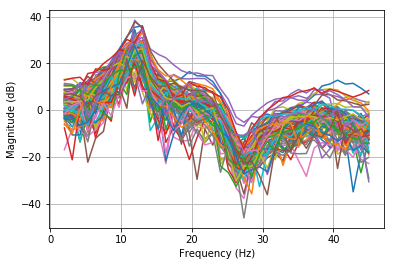

In [12]:
fig = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(fvec,functions.mag2db(np.abs(freq_model[g,:])))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
#mpl.plot(fvec,mag2db(np.abs(freq_model)))

### Adding some real data

Now, we can import some real MEG data, and process it. Let's choose a random file.

In [13]:
filename = '/Users/Megan/RajLab/MEG-chang/8002.101/DK_timecourse_20.h5'

In [14]:
mybrain.add_MEG(filename)

In [15]:
orderpath = '/Users/Megan/RajLab/BRAIN/SCFC-spectral-python/SCFC/dictionaries/HCP_list.h5'

In [16]:
mybrain.order_MEG(orderpath)

In [17]:
datakeys = list(mybrain.MEGdata.keys())

Let's look at the order in the HCP file for comparison.

In [18]:
standardlist = pth.read_hdf5(orderpath)

In [19]:
i=0
while i < 68:
    if datakeys[i] != standardlist[i]:
        print('Mismatch occurred at ' + str2int(i) + '!')
        i += 1
    else:
        i += 1
    

OK, so the matching seems to work. Let's plot the raw MEG data, so we can compare to the filtering. 

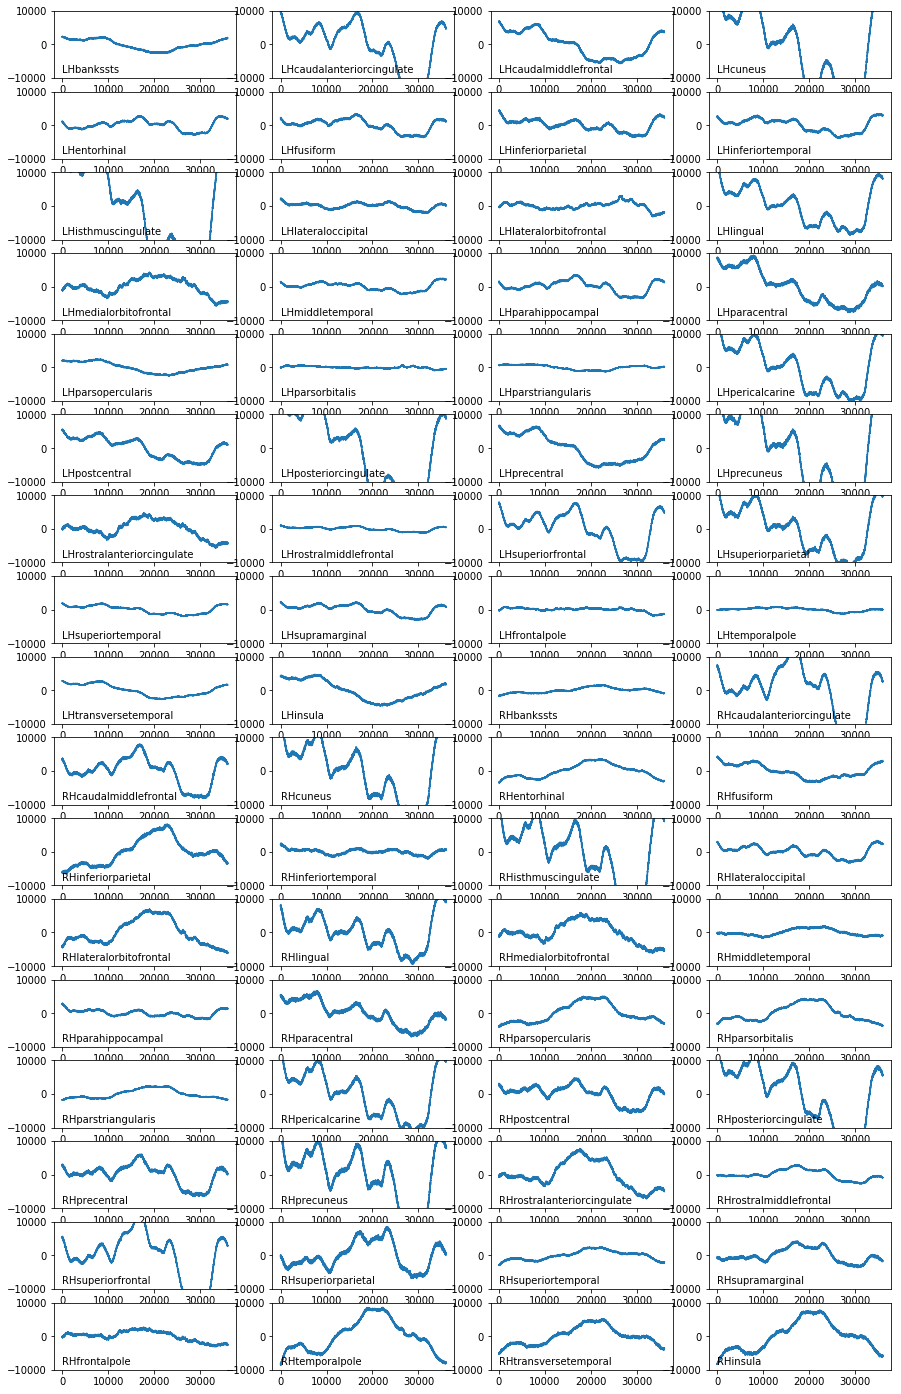

In [20]:
fig1, axes1 = mpl.subplots(17,4,figsize=(15,25))
ax1 = axes1.ravel()
i = 0
for key in list(mybrain.MEGdata.keys()):
    ax1[i].plot(mybrain.MEGdata[key])
    ax1[i].text(0,-8500, key)
    ax1[i].set_ylim([-10000,10000])
    i += 1

OK, we need to apply the filter to this data so we get something a little more like what we would expect. The filter function returns the FFT'ed form (actually we're skipping the function here as it is behaving strangely -- will fix)

In [21]:
fsampling=600
fmin=2
fmax=45
regions =68
fs = fsampling

hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs, desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size 

In [22]:
FMEGdata = {}

In [23]:
MEGdata = mybrain.MEGdata

In [24]:
import nitime.algorithms as tsa

In [25]:
for key in list(MEGdata.keys()):
        data = MEGdata[key]
        data = data.astype(float)
        row = np.asarray(data)
        q = lfilter(hbp, 1, row)
        q = q[ind_del:-1]
        ds_q = decimate(q, 4, axis = 0)
        f, psd, nu = tsa.multi_taper_psd(ds_q, Fs = fs/4, NW = 3, BW = 1, adaptive = False, jackknife = False)
        Fdata = np.convolve(psd, lpf, mode = 'same')
        FMEGdata[key] = Fdata

/Users/Megan/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)
/Users/Megan/anaconda3/lib/python3.6/site-packages/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/Users/Megan/anaconda3/lib/python3.6/site-packages/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))


Let's turn the output in to an array and then take the mean.

In [26]:
length = len(FMEGdata['RHinsula'])
length

4488

In [27]:
FMEGarray = np.zeros((68, length))
i = 0
for key in list(FMEGdata.keys()):
    FMEGarray[i,:] = FMEGdata[key]
    i+=1

In [28]:
meanfiltered = np.mean(FMEGarray, axis = 0)

In [29]:
meanfiltered.shape

(4488,)

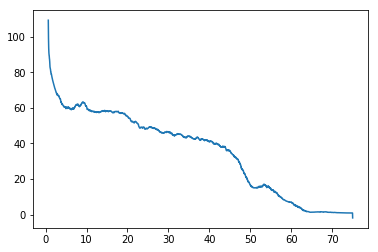

In [31]:
mpl.plot(f[40:], functions.mag2db(meanfiltered[40:]))